In [1]:
# Simulate decaying correlation. 

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyproj import Proj
from shapely.geometry import Point

## Load location data for industry p
Pass point coordinates to separate columns 'loc_x' and 'loc_y'.

Convert to metres (UTM, Easting Northing) so to have metrical units and work more confortably. However keep in mind there will be a little distortion

In [5]:
gpd.read_file('./data/locations_data/NG_point_1.shp').head()

,STATE,COUNTY,PLANT,ZIPCODE,STATUS,CAPACITY,geometry
0,CO,Weld,Redtail Gas Plant,80742,Active,20.0,POINT (-103.9806987444521 40.54616715790659)
1,AL,Mobile,Hatters Pond Gas Plant,36525,Active,70.0,POINT (-88.01355335527282 30.87934662953371)
2,TX,Scurry,Snyder Gasoline Plant,79549,Active,90.0,POINT (-100.6051852583855 33.02811065588871)
3,CO,Garfield,Hay Canyon Treating Facility,81524,Active,25.0,POINT (-108.9485560265749 39.20001702484542)
4,AL,Conecuh,Castleberry,36432,Active,9.0,POINT (-87.14239632743687 31.29116545735495)


In [286]:
# Either Natural Gas or Oil Refineries. Load and make a column called value.

industry_name = 'Natural Gas'
NG = gpd.read_file('./data/locations_data/NG_point_1.shp'); NG.crs = {'init': 'epsg:4326'}
NG['value'] = NG['CAPACITY']

industry_name = 'Oil Refineries'
OR = gpd.read_file('./data/locations_data/U.S._Petroleum_Refineries.shp')
OR['value'] = OR[[col for col in OR.columns if 'Mbpd' in col]].sum(1)
OR = OR.loc[~OR.State.isin(['Alaska', 'Hawaii'])] # Keep contiguous US

In [71]:
import numexpr as ne

def groupby_grid(df, log10_size, x_col, y_col):
    grouped = df.groupby([df[x_col].round(-log10_size), df[y_col].round(-log10_size)])
    return grouped

def flap(x, y, t, b, xm, ym):
    a = -np.sqrt((x-xm)**2 + (y-ym)**2)/b
    return t*ne.evaluate('exp(a)')/(2*b)


def sum_pdfs(df, num_int = 10, margin = 100, return_mesh = False):
#     min_ = df.min()
#     x_min = min_[-2] - margin; y_min = min_[-1] - margin
#     max_ = df.max()
#     x_max = max_[-2] + margin; y_max = max_[-1] + margin

    x_min = -1600; y_min = 2800
    x_max = 2300; y_max = 5600
    
    x = np.arange(x_min, x_max, num_int)
    y = np.arange(y_min, y_max, num_int)
    
    xx, yy = np.meshgrid(x, y, sparse=True)
    z_cum = np.zeros((len(y), len(x)))
    for v in df.values:
        z = flap(xx, yy, v[0], v[1], v[2], v[3])
        z_cum = z_cum + z
    if return_mesh:
        return x, y, z_cum
    else:
        return z_cum

## Computation. Continuous and discrete cases.

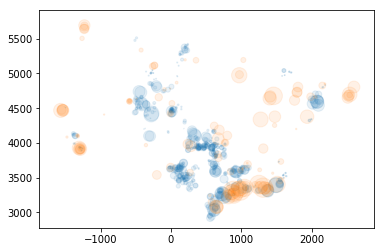

In [276]:
def groupby_grid(df, log10_size, x_col, y_col):
    grouped = df.groupby([df[x_col].round(-log10_size), df[y_col].round(-log10_size)])
    return grouped


dist = [.3, 1, 3, 6, 10, 20, 30, 50, 75, 100, 300, 500]  # distances (km) used in letting corr decay
# dist = [3, 30, 75, 100, 300]  # distances (km) used in letting corr decay
# dist = [10, 20, 30]  # distances (km) used in letting corr decay
D = len(dist)
N = 20


widths = np.array([1, 3, 10, 30, 100]) # influence radios in km
# widths = np.array([ 3, 30]) # influence radios in km
B = len(widths)

df_disc_list = []
df_cont_list = []

n_grids = 2
n_industries = 2
for j in range(n_industries):
    
    indu_p = [NG, OR][j]
    industry_name = ['Natural Gas', 'Oil Refineries'][j]
    
    # Get coordinates in separate columns
    loc_values = np.array([(p.x, p.y) for p in indu_p.geometry])
    indu_p['loc_x'] = loc_values[:, 0]
    indu_p['loc_y'] = loc_values[:, 1]

    # Projection to UTM 14S (it's centered on US midwest).
    myProj = Proj("+proj=utm +zone=14S, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

    # Project
    indu_p['loc_x'], indu_p['loc_y'] = myProj(indu_p['loc_x'].values, indu_p['loc_y'].values)
    # Units from meters to km
    indu_p['loc_x']  = indu_p['loc_x']/1e3; 
    indu_p['loc_y']  = indu_p['loc_y']/1e3; 

    # Check what we got so far
    plt.scatter(indu_p['loc_x'], indu_p['loc_y'], s = indu_p['value']/5., alpha = .1)
    
    ### Create jittered Q industry locations
    # For industry q, copy industry p, and apply an increasing jitter. 
    indu_q = indu_p.copy()[['value', 'geometry']].reset_index(drop = True)
    
    cov_results = np.zeros((D, N))
    x_0 = indu_p['loc_x']
    y_0 = indu_p['loc_y']

    for d in range(D):
        # For each distance d
        for n in range(N):
            # For each repetition n. Set the name of the x, y columns. 
            x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
            y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'

            # Random choose angle, shift original x, y by d.
            angles = np.pi * np.random.uniform(0, 2, len(indu_q))
            x_d = dist[d] * np.cos(angles); y_d = dist[d] * np.sin(angles)
            # jittered q locations to column
            jit_values = np.array([x_0, y_0]).T + np.array([x_d, y_d]).T

            indu_q[x_col] = jit_values[:, 0]
            indu_q[y_col] = jit_values[:, 1]
            
    for b in range(B):
        int_results = np.zeros((D, N))
        for d in range(D):
            for n in range(N):
                x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
                y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'

                indu_p['b'] = widths[b]
                indu_q['b'] = widths[b]

                z_cump = sum_pdfs(indu_p[['value', 'b', 'loc_x', 'loc_y']])
                z_cumq = sum_pdfs(indu_q[['value', 'b', x_col, y_col]])
                # Make them PDFs. That is normalize by their sum, so they sum to 1
                z_cump = z_cump/sum(sum(z_cump))
                z_cumq = z_cumq/sum(sum(z_cumq))

                int_results[d, n] = sum(sum(z_cump * z_cumq))/sum(sum(z_cump * z_cump))
                
        df_cont = pd.DataFrame(int_results.mean(1), index = dist, columns=['mean'])
        df_cont.index.name = 'b_dist'
        df_cont['b_width'] =  widths[b]# in km
        df_cont['industry'] = industry_name

        df_cont_list += [df_cont]

    for i in range(n_grids): # Artificial admin area grid size in logs
        grid_size = [1, 2][i]
        cov_results = np.zeros((D, N))
        for d in range(D):
            for n in range(N):
        #         print(d, n)
                x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
                y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'
                indu_q_i = indu_q[['value', x_col, y_col]]
                indu_q_i['geometry'] = list(zip(indu_q_i[x_col], indu_q_i[y_col]))
                indu_q_i['geometry'] = indu_q_i['geometry'].apply(Point)
                indu_q_i = gpd.GeoDataFrame(indu_q_i)

                df = pd.concat([groupby_grid(indu_p, grid_size, 'loc_x', 'loc_y')[['value']].sum(), 
                                   groupby_grid(indu_q_i, grid_size, x_col, y_col)[['value']].sum()], axis = 1).fillna(0)
#                 normed = df/df.sum()
                normed = df/np.sqrt(np.square(df).sum())
                dot = normed.iloc[:, 0].dot(normed.iloc[:, 1])
                #cosine, but it's a normalization, so that 
                cov_results[d, n] = dot#/(sum(normed.iloc[:, 0]*normed.iloc[:, 0]))

        df_disc = pd.DataFrame(cov_results.mean(1), index = dist, columns=['mean'])
        df_disc.index.name = 'b_dist'
        df_disc['grid_size'] = np.power(10, grid_size) # in km
        df_disc['industry'] = industry_name

        df_disc_list += [df_disc]

# plt.show()

result_discrete = pd.concat(df_disc_list)
result_continuous = pd.concat(df_cont_list)

## Illustrate 2D functions, grid and other parameters.

In [305]:
z_cump_l = []
x_ = []; y_ = []
disc_l = []
grid_size = 2



for j in [0, 1]:

    indu_p = [NG, OR][j]
    indu_p['b'] = 30

    # industry_name = ['Natural Gas', 'Oil Refineries'][j]

    # Get coordinates in separate columns
    loc_values = np.array([(p.x, p.y) for p in indu_p.geometry])
    indu_p['loc_x'] = loc_values[:, 0]
    indu_p['loc_y'] = loc_values[:, 1]

    # Projection to UTM 14S (it's centered on US midwest).
    myProj = Proj("+proj=utm +zone=14S, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

    # Project
    indu_p['loc_x'], indu_p['loc_y'] = myProj(indu_p['loc_x'].values, indu_p['loc_y'].values)
    # Units from meters to km
    indu_p['loc_x']  = indu_p['loc_x']/1e3; 
    indu_p['loc_y']  = indu_p['loc_y']/1e3; 

    # Check what we got so far

    x, y, z_cump = sum_pdfs(indu_p[['value', 'b', 'loc_x', 'loc_y']], return_mesh = True)
    z_cump_l += [z_cump]
    x_ += [x]; y_ += [y]
    
    disc = groupby_grid(indu_p, grid_size, 'loc_x', 'loc_y')[['value']].sum()
    
    disc_l += [disc]


In [288]:
# Load US shape

US = gpd.read_file('./data/cb_2017_us_nation_20m/cb_2017_us_nation_20m.shp'); US.crs = {'init': 'epsg:4326'}
US.geometry = US.geometry.to_crs("+proj=utm +zone=14S, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
US.geometry = US.geometry.scale(.001, .001, origin = (0, 0))


In [324]:
# counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp'); counties.crs = {'init': 'epsg:4326'}
# plt.hist(np.sqrt(counties.ALAND), 150)
# plt.xlim(0, 100000)
# plt.show()
np.sqrt(counties.ALAND).median()/3

13175.469137757485

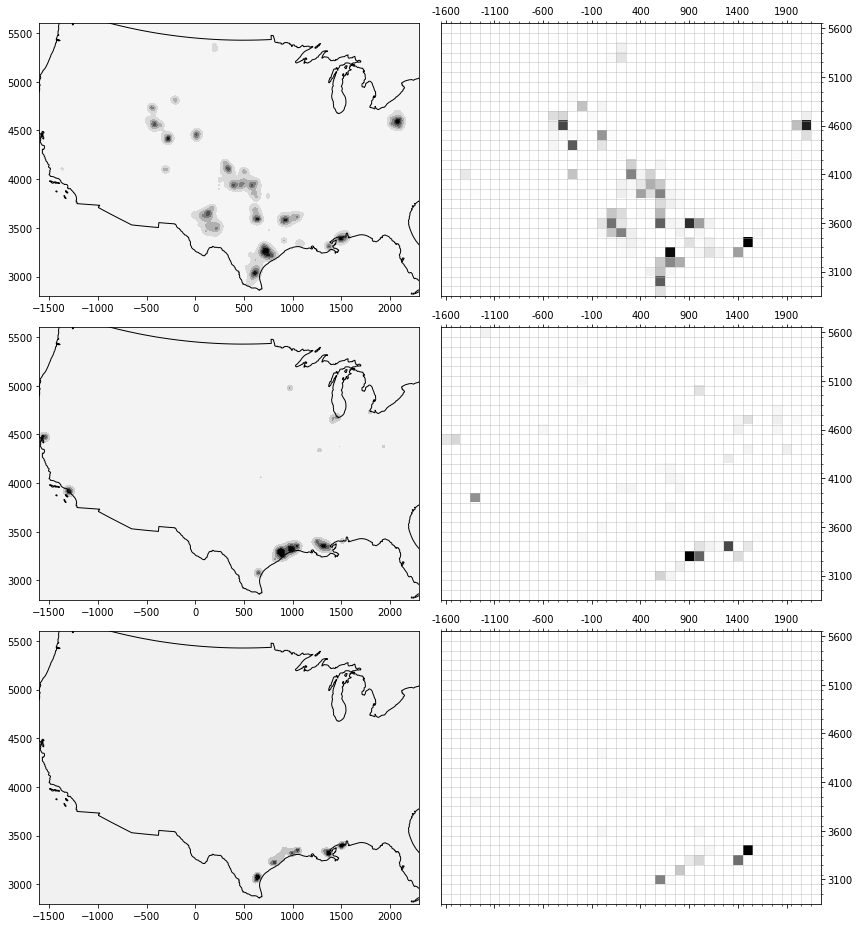

In [334]:
#     x_min = -1600; y_min = 2800
#     x_max = 2300; y_max = 5600

fig, axs = plt.subplots(3, 2, figsize = (12, 13))

# CONTINUOUS PLOTS
ax = axs[0, 0]
ax.contourf(x_[0],y_[0],z_cump_l[0], vmin = 0, vmax = 30, cmap = 'Greys')
US['geometry'].plot(facecolor="none", edgecolor = 'k', ax = ax)
ax.set_xlim(-1600, 2300)
ax.set_ylim(2800, 5600)
ax.set_aspect('equal')

ax = axs[1, 0]
h = ax.contourf(x_[1],y_[1],z_cump_l[1], vmin = 0, vmax = 50, cmap = 'Greys')
US['geometry'].plot(facecolor="none", edgecolor = 'k', ax = ax)
ax.set_xlim(-1600, 2300)
ax.set_ylim(2800, 5600)
ax.set_aspect('equal')

ax = axs[2, 0]
h = ax.contourf(x_[0],y_[0],z_cump_l[0] * z_cump_l[1], vmin = 0, vmax = 350, cmap = 'Greys')
US['geometry'].plot(facecolor="none", edgecolor = 'k', ax = ax)
ax.set_xlim(-1600, 2300)
ax.set_ylim(2800, 5600)
ax.set_aspect('equal')

# DISCRETE PLOTS

ax = axs[0, 1]
data_df = disc_l[0].unstack()['value'].T
data_df = data_df.reindex(np.arange(5600, 2800, -100)).fillna(0)
data_df = data_df.reindex(np.arange(-1600, 2300, 100), axis = 1).fillna(0)
ax.matshow(data_df, cmap = 'Greys')
ax.set_xticks(range(len(data_df.columns))[::5])
ax.set_xticklabels(data_df.columns[::5])
ax.set_yticks(range(len(data_df.index))[::5])
ax.set_yticklabels(data_df.index[::5])

ax.set_xticks(np.arange(-.5, len(data_df.columns)-1, 1), minor=True)
ax.set_yticks(np.arange(-.5, len(data_df.index) - 1, 1), minor=True)
ax.grid(which='minor', alpha=.5)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_aspect('equal')


ax = axs[1, 1]
data_df = disc_l[1].unstack()['value'].T
data_df = data_df.reindex(np.arange(5600, 2800, -100)).fillna(0)
data_df = data_df.reindex(np.arange(-1600, 2300, 100), axis = 1).fillna(0)
ax.matshow(data_df, cmap = 'Greys')
ax.set_xticks(range(len(data_df.columns))[::5])
ax.set_xticklabels(data_df.columns[::5])
ax.set_yticks(range(len(data_df.index))[::5])
ax.set_yticklabels(data_df.index[::5])
ax.set_xticks(np.arange(-.5, len(data_df.columns)-1, 1), minor=True)
ax.set_yticks(np.arange(-.5, len(data_df.index) - 1, 1), minor=True)
ax.grid(which='minor', alpha=.5)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_aspect('equal')

ax = axs[2, 1]
data_df = (disc_l[0]*disc_l[1]).unstack().fillna(0)['value'].T.sort_index(ascending = False)
data_df = data_df.reindex(np.arange(5600, 2800, -100)).fillna(0)
data_df = data_df.reindex(np.arange(-1600, 2300, 100), axis = 1).fillna(0)
ax.matshow(data_df, cmap = 'Greys')
ax.set_xticks(range(len(data_df.columns))[::5])
ax.set_xticklabels(data_df.columns[::5])
ax.set_yticks(range(len(data_df.index))[::5])
ax.set_yticklabels(data_df.index[::5])

ax.set_xticks(np.arange(-.5, len(data_df.columns)-1, 1), minor=True)
ax.set_yticks(np.arange(-.5, len(data_df.index) - 1, 1), minor=True)
ax.grid(which='minor', alpha=.5)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_aspect('equal')

# plt.show()
plt.tight_layout()
plt.savefig('./areal_point_demo.png')

In [132]:
# Test. One plant per county.
# indu_p = indu_p.groupby('AREA_FIPS').first().reset_index()

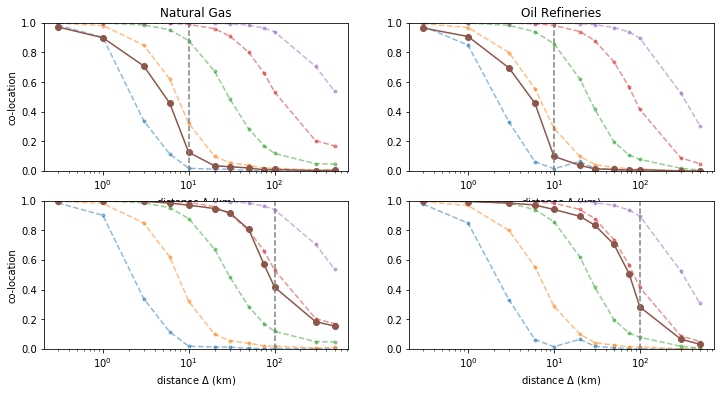

In [335]:
result = result_continuous

n_widths = result.b_width.nunique()

fig, axs = plt.subplots(n_industries, n_grids, figsize = (12, 6))


for j in range(result.industry.nunique()):
    indu = result.industry.unique()[j]
    for i in range(result_discrete.grid_size.nunique()):

        for k in range(n_widths):
            bw = result.b_width.unique()[k]
            ax = axs[i][j]
            result.loc[(result.b_width == bw) & (result.industry == indu)]['mean'].plot(
                marker = '.', linestyle = '--', alpha = .5, ax = ax)
            ax.set_xscale('log')
            ax.set_ylim(0, 1)
            if i == 0: ax.set_title(indu)
            if j == 0: ax.set_ylabel('co-location')


for j in range(result_discrete.industry.nunique()):
    indu = result_discrete.industry.unique()[j]
    for i in range(result_discrete.grid_size.nunique()):
        gs = result_discrete.grid_size.unique()[i]
        ax = axs[i][j]
        result_discrete.loc[(result_discrete.grid_size == gs) & (result_discrete.industry == indu)]['mean'].plot(
            marker = 'o', ax = ax)
        ax.set_xscale('log')
        ax.set_ylim(0, 1)
        ax.axvline(gs, color = '.5', linestyle = '--')
        if i == 0: ax.set_title(indu)
        if i == 1: ax.set_xlabel(r'distance $\Delta$ (km)')
        else: ax.set_xlabel(r'distance $\Delta$ (km)')

plt.savefig('./cont_disc_simu.png')

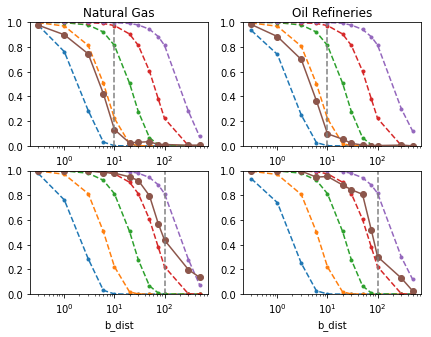

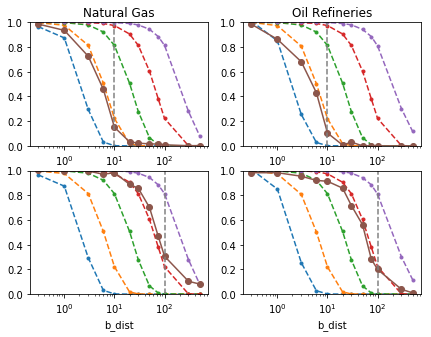